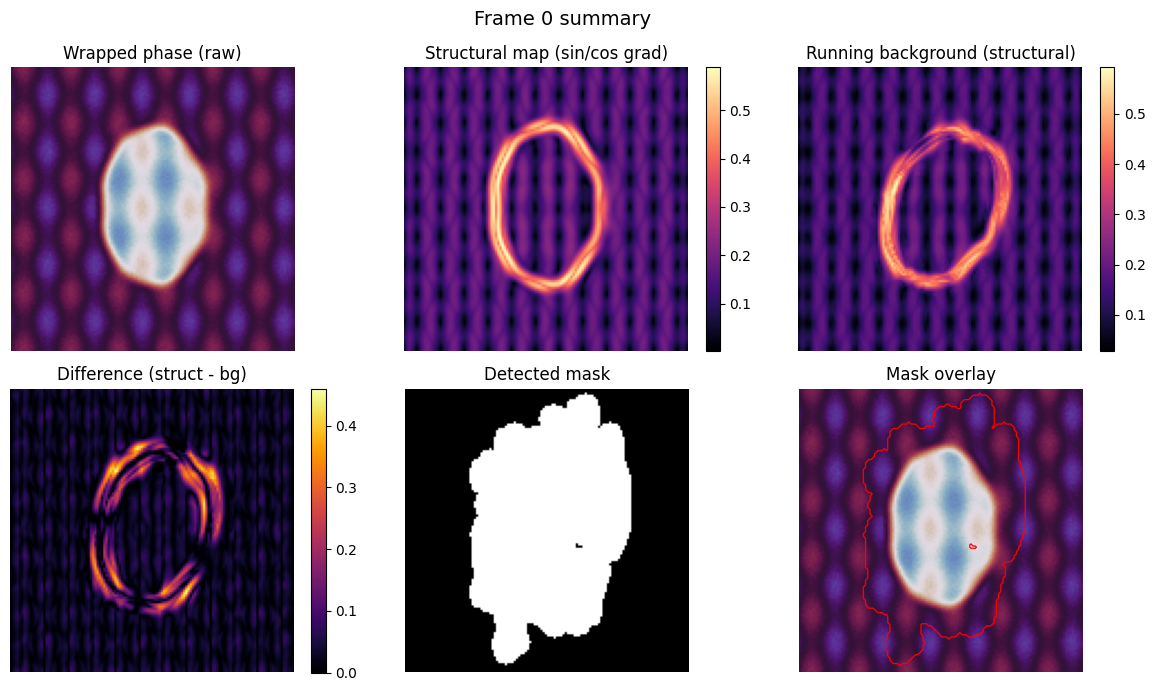

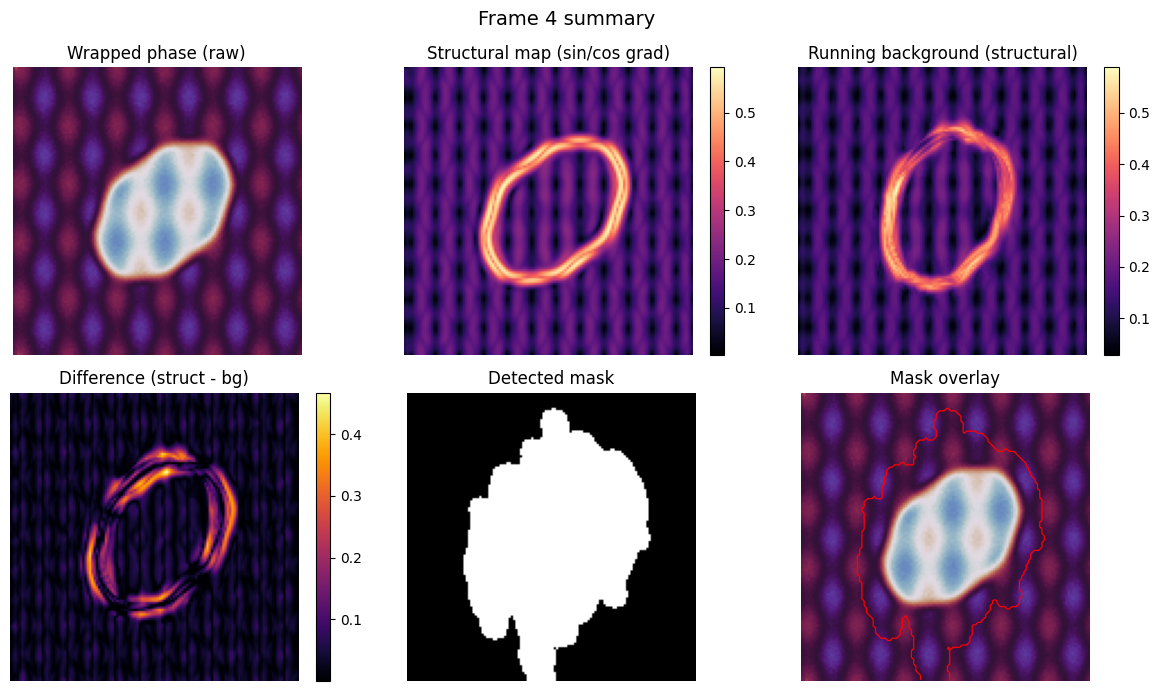

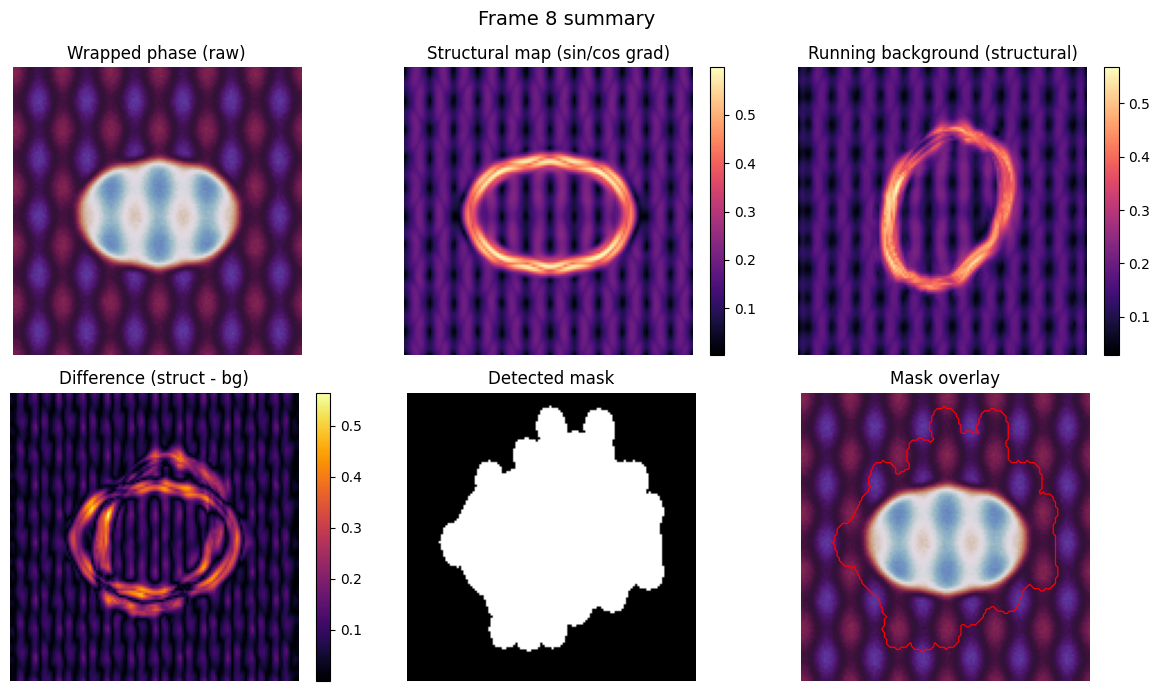

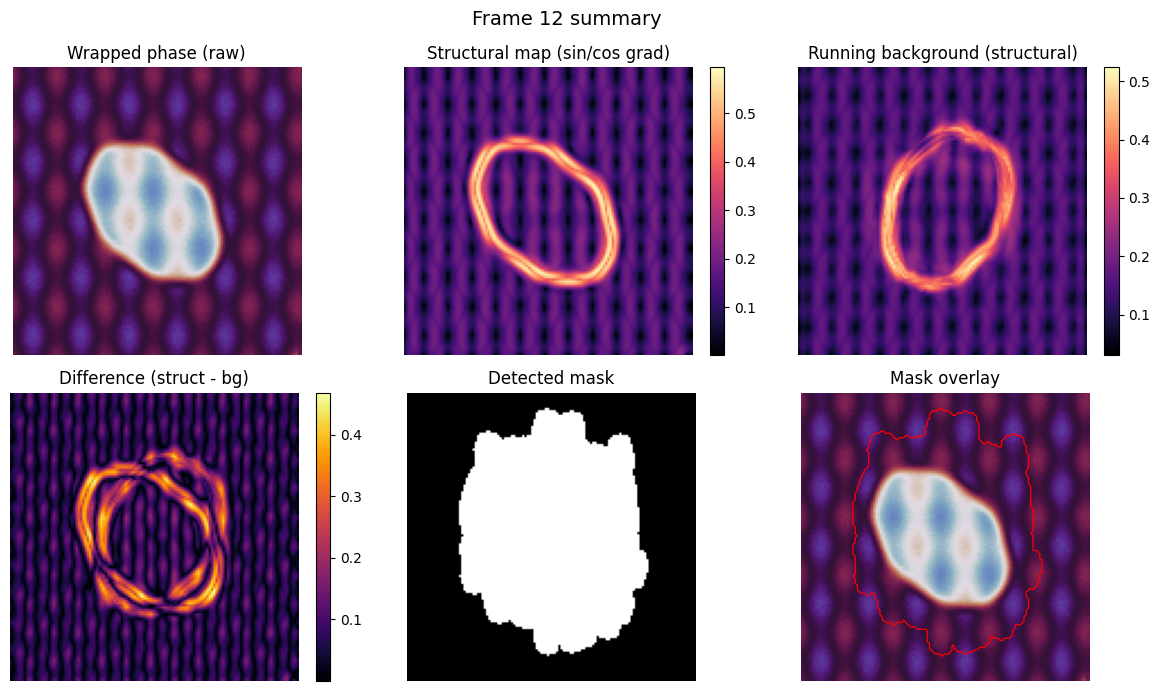

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_gradient_magnitude, gaussian_filter, rotate
from skimage import morphology

# -------------------------------------------------------
# --- Helpers: ellipsoid creation & wrapping -----------
# -------------------------------------------------------

def make_ellipsoid(N=128, rx=30, ry=45, cx=None, cy=None, amplitude=1.0, blur_sigma=2.0):
    """Return an ellipse (binary) optionally blurred a bit for smooth boundaries."""
    y, x = np.indices((N, N))
    if cx is None:
        cx = N // 2
    if cy is None:
        cy = N // 2
    inside = ((x - cx)**2 / float(rx**2) + (y - cy)**2 / float(ry**2)) <= 1.0
    ell = amplitude * inside.astype(float)
    if blur_sigma is not None and blur_sigma > 0:
        ell = gaussian_filter(ell, sigma=blur_sigma)
    return ell

def wrap_phase(phase):
    """Wrap into [-pi, pi]."""
    return (phase + np.pi) % (2*np.pi) - np.pi

# -------------------------------------------------------
# --- Simulation: rotating object + drifting fringes ----
# -------------------------------------------------------

def generate_rotating_sample_sequence(N=128, n_frames=20, noise=0.05,
                                      rx=25, ry=40, amp=1.0, wrap_factor=2.0):
    """
    Simulate rotating 2D projections (wrapped phase) of an ellipsoid-like object.
    Returns: numpy array shape (n_frames, N, N)
    """
    # create base object once
    object2D = make_ellipsoid(N=N, rx=rx, ry=ry, amplitude=amp, blur_sigma=2.0)

    y, x = np.indices((N, N))
    frames = []
    for i in range(n_frames):
        angle = i * (180.0 / n_frames)  # rotate half-turn across sequence
        rotated = rotate(object2D, angle=angle, reshape=False, order=1, mode='reflect')

        # small translation jitter (simulate stage / sample motion)
        tx = int(np.round(1.5 * np.sin(i * 2*np.pi / n_frames)))
        ty = int(np.round(1.0 * np.cos(i * 2*np.pi / n_frames)))
        if tx != 0 or ty != 0:
            rotated = np.roll(np.roll(rotated, tx, axis=1), ty, axis=0)

        # low-contrast fringy background that slowly drifts
        drift = 0.03 * i
        bg = 0.6 * (np.sin(2 * np.pi * (x / (N/6.0) + drift)) +
                    0.5 * np.cos(2 * np.pi * (y / (N/5.0) + 0.5*drift)))

        # combine: scale object and wrap
        phase = wrap_factor * rotated + bg + noise * np.random.randn(N, N)
        wrapped = wrap_phase(phase)

        frames.append(wrapped)
    return np.array(frames)


# -------------------------------------------------------
# --- Dynamic mask algorithm (structural map based) ----
# -------------------------------------------------------

def structural_map(phase, sigma=1.8):
    """Phase structure map robust to wrapping: gradient of sin and cos."""
    gm = (gaussian_gradient_magnitude(np.sin(phase), sigma=sigma) +
          gaussian_gradient_magnitude(np.cos(phase), sigma=sigma))
    return gm

def update_background(bg, new_frame, alpha=0.02):
    return (1 - alpha) * bg + alpha * new_frame

def clean_mask(mask, min_size=200, dilate=3):
    mask = morphology.remove_small_objects(mask, min_size=min_size)
    mask = morphology.remove_small_holes(mask, area_threshold=min_size)
    mask = morphology.binary_closing(mask, morphology.disk(2))
    mask = morphology.binary_dilation(mask, morphology.disk(dilate))
    return mask

def dynamic_mask_wrapped_phase(frames, alpha=0.02, sigma=1.8, thresh_factor=1.2, min_size=200, dilate=4):
    """
    Create dynamic masks for a sequence of wrapped phase images with slow background drift.
    """
    struct_maps = [structural_map(f, sigma=sigma) for f in frames]
    bg_map = np.median(struct_maps[:min(5, len(struct_maps))], axis=0)
    masks = []
    bg_evolution = [bg_map.copy()]
    for smap in struct_maps:
        diff = np.abs(smap - bg_map)
        diff = gaussian_filter(diff, sigma=1.0)  # smooth difference map
        norm = diff / (np.max(diff) + 1e-6)      # normalize
        t = np.median(norm) + thresh_factor * np.std(norm) * 0.8
        mask = norm > t
        mask = clean_mask(mask, min_size=min_size, dilate=dilate)
        masks.append(mask)
        bg_map = update_background(bg_map, smap, alpha=alpha)
        bg_evolution.append(bg_map.copy())
    return masks, struct_maps, bg_evolution



# -------------------------------------------------------
# --- Run simulation and masking ------------------------
# -------------------------------------------------------

N = 128
n_frames = 16
frames = generate_rotating_sample_sequence(N=N, n_frames=n_frames,
                                           noise=0.04, rx=24, ry=36, amp=1.2,
                                           wrap_factor=3.0)

masks, struct_maps, bg_maps = dynamic_mask_wrapped_phase(frames,
                                                         alpha=0.025,
                                                         sigma=1.6,
                                                         thresh_factor=0.1,
                                                         min_size=300,
                                                         dilate=5)

# -------------------------------------------------------
# --- Visualization: montage + overlay for several frames
# -------------------------------------------------------

def show_frame_summary(idx, frames, struct_maps, bg_maps, masks):
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))
    plt.suptitle(f"Frame {idx} summary", fontsize=14)

    axes[0,0].imshow(frames[idx], cmap='twilight', origin='lower')
    axes[0,0].set_title("Wrapped phase (raw)")
    axes[0,0].axis('off')

    im1 = axes[0,1].imshow(struct_maps[idx], cmap='magma', origin='lower')
    axes[0,1].set_title("Structural map (sin/cos grad)")
    axes[0,1].axis('off')
    fig.colorbar(im1, ax=axes[0,1], fraction=0.046)

    im2 = axes[0,2].imshow(bg_maps[idx], cmap='magma', origin='lower')
    axes[0,2].set_title("Running background (structural)")
    axes[0,2].axis('off')
    fig.colorbar(im2, ax=axes[0,2], fraction=0.046)

    diff = np.abs(struct_maps[idx] - bg_maps[idx])
    im3 = axes[1,0].imshow(diff, cmap='inferno', origin='lower')
    axes[1,0].set_title("Difference (struct - bg)")
    axes[1,0].axis('off')
    fig.colorbar(im3, ax=axes[1,0], fraction=0.046)

    axes[1,1].imshow(masks[idx], cmap='gray', origin='lower')
    axes[1,1].set_title("Detected mask")
    axes[1,1].axis('off')

    axes[1,2].imshow(frames[idx], cmap='twilight', origin='lower')
    axes[1,2].contour(masks[idx], colors='red', linewidths=0.9)
    axes[1,2].set_title("Mask overlay")
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

# show a few frames
for ii in [0, n_frames//4, n_frames//2, 3*n_frames//4]:
    show_frame_summary(ii, frames, struct_maps, bg_maps, masks)
